In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import random
from scipy import ndarray
import skimage as sk
import skimage.io
from skimage import transform
from skimage import util
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

In [2]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator

In [3]:
#device_name = tf.test.gpu_device_name()
#if device_name != '/device:GPU:0':
#  raise SystemError('GPU device not found')
#print('Found GPU at: {}'.format(device_name))"""

In [4]:
IMAGE_SIZE =  [224,224]
model_vgg = VGG16(input_shape = IMAGE_SIZE + [3], weights='imagenet', include_top = False)
model_vgg.summary()

for layer in model_vgg.layers:
    layer.trainable = False

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

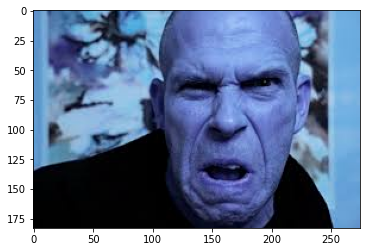

In [5]:
img = cv2.imread("angry2.jpg")
plt.imshow(img)

In [6]:
train_path = 'data4/train'
valid_path = 'data4/test'

In [7]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 16,
                                                 class_mode = 'binary')

test_set = test_datagen.flow_from_directory(valid_path,
                                            target_size = (224, 224),
                                            batch_size = 16,
                                            class_mode = 'binary')

Found 12309 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [8]:
Classes = ['angry','disgust','fear','happy','neutral','sad','surprise']

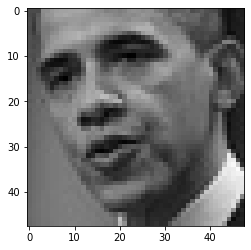

In [9]:
for cat in Classes:
    path = os.path.join(train_path, cat)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img))
        plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
        plt.show()
        break
    break

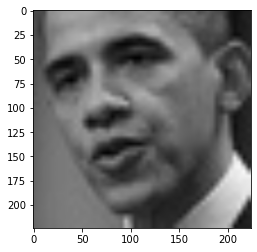

(224, 224, 3)

In [10]:
img_size = 224
new_array  = cv2.resize(img_array, (img_size, img_size))
plt.imshow(cv2.cvtColor(new_array, cv2.COLOR_BGR2RGB))
plt.show()
new_array.shape

In [11]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

In [12]:
early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

In [13]:
model_vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [14]:
final_output = model_vgg.output
final_output = Flatten()(final_output)
final_output = layers.Dropout(0.3)(final_output)
final_output = layers.Dense(128)(final_output)
final_output = layers.Activation('relu')(final_output)
final_output = layers.Dense(128)(final_output)
final_output = layers.Activation('relu')(final_output)
final_output = layers.Dropout(0.3)(final_output)
final_output = layers.Dense(7, activation='softmax')(final_output)

In [15]:
new_model  = keras.Model(inputs = model_vgg.input, outputs = final_output)
new_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [16]:
new_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam",metrics=["accuracy"])

In [17]:
#with tf.device('/device:GPU:0'):
history = new_model.fit_generator(training_set,validation_data=test_set,epochs=15,callbacks=[early_stopping],steps_per_epoch=len(training_set),validation_steps=len(test_set))

C:\Users\julja\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
770/770 [==============================] - 3130s 4s/step - loss: 1.9188 - accuracy: 0.2379 - val_loss: 1.7741 - val_accuracy: 0.2342
Epoch 2/15
770/770 [==============================] - 3116s 4s/step - loss: 1.6973 - accuracy: 0.3012 - val_loss: 1.6931 - val_accuracy: 0.2959
Epoch 3/15
770/770 [==============================] - 3180s 4s/step - loss: 1.6822 - accuracy: 0.3106 - val_loss: 1.6067 - val_accuracy: 0.3750
Epoch 4/15
770/770 [==============================] - 3023s 4s/step - loss: 1.6499 - accuracy: 0.3471 - val_loss: 1.6689 - val_accuracy: 0.3178
Epoch 5/15
770/770 [==============================] - 3001s 4s/step - loss: 1.6113 - accuracy: 0.3643 - val_loss: 1.5791 - val_accuracy: 0.3807
Epoch 6/15
770/770 [==============================] - 2961s 4s/step - loss: 1.5948 - accuracy: 0.3631 - val_loss: 1.5824 - val_accuracy: 0.3749
Epoch 7/15
770/770 [==============================] - 2934s 4s/step - loss: 1.5779 - accuracy: 0.3768 - val_loss: 1.5377 - val_accuracy:

Minimum validation loss: 1.4801490306854248


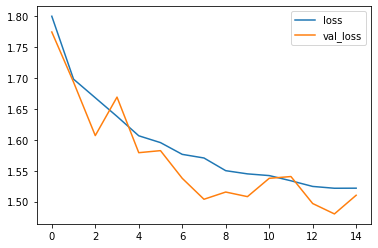

In [18]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

In [19]:
new_model.save('my_model_with_important_data2')

INFO:tensorflow:Assets written to: my_model_with_important_data2\assets


In [20]:
test = tf.keras.models.load_model('my_model_with_important_data2')